# Adaptive Clustering based Intrusion Detection
---
<p style="font-size: 1.5em; line-height: 1.2em;">In this notebook, we build an Intrusion Detection System based on our classifier-agnostic Adaptive Clustering approach as presented in our paper: <a href="https://homepages.inf.ed.ac.uk/ppatras/pub/infocom21.pdf" target="_blank">Adaptive Clustering-based Malicious Traffic Classification at the Network Edge</a>. This approach obtains a perfect Accuracy and F1-score of <b>100.0%</b> with a False Alarm Rate of <b>0%</b>, making it the new state-of-the-art approach for intrusion detection.</p>

<p style="font-size: 1.5em; line-height: 1.2em;">In this notebook, we will perform a multi-label classification task on the preprocessed <a href="https://registry.opendata.aws/cse-cic-ids2018/" target="_blank">CSE-CIC-IDS 2018</a> dataset.</p>
<p style="padding-left: 10px; margin-left: 20px; border-left: 5px solid #CCC; font-style: italic;">
Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani, “Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”, 4th International Conference on Information Systems Security and Privacy (ICISSP), Portugal, January 2018
</p>

## Imports

In [1]:
#!/usr/bin/env python

__author__ = "Alec F."
__license__ = "GPL"
__version__ = "1.0.1"


import os
import sys

from core.models.network import AdaptiveClustering
from core.utils.misc import extend_dataset
from core.utils import Dataset

import json

import pandas as pd
import numpy as np
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from core.models.RandomForest import RandomForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as prf, accuracy_score

from pprint import pprint

## Helpers

We use these helpers functions throughout all our experiments for simplify our main code and improve its readability. In all our experiments, our datasets are separated to approximately obtain a 70/30 train-test split from randomly sampled data. We use the pickle library to save our trained model and defined a set of metrics that are commonly used for classification tasks.

In [2]:
def load_dataset(dataset_path):
    global categories
    if not os.path.exists(dataset_path):
        print(f"Dataset not found: {dataset_path}")
        sys.exit(1)

    df = pd.read_csv(dataset_path, index_col=False)
    
    # For binary classification, uncomment the following line
    # df['Label'] = np.where(df['Label'] != "Normal", "Attack", df['Label'])
    
    train_test_split = .7
    msk = np.random.rand(len(df)) < train_test_split
    train_df = df[msk]
    test_df = df[~msk]

    return train_df, test_df, df


def save_model(rf, filename):
    with open(filename, 'wb') as f:
        pkl.dump(rf, f)


def load_model(filename):
    with open(filename, 'rb') as f:
        m = pkl.load(f)
    return m


class metrics(object):

    def __init__(self, tp=None, tn=None, fp=None, fn=None):
        super(metrics, self).__init__()

        self.tp, self.tn, self.fp, self.fn = tp, tn, fp, fn

        self.metrics = {}

    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    def detection_rate(self):
        return self.tp / (self.tp + self.fn)

    def false_alarm_rate(self):
        return self.fp / (self.fp + self.tn)

    def precision(self):
        return self.tp / (self.tp + self.fp)

    def f1(self):
        prec = self.precision()
        rec = self.detection_rate()
        return 0 if (prec + rec) == 0 else 2 * (prec * rec) / (prec + rec)

    def get_metrics(self):
        self.metrics = {"Acc": self.accuracy(), "DR/Recall": self.detection_rate(), "FAR": self.false_alarm_rate(),
                        "PRECISION": self.precision(), "F1 SCORE": self.f1()}
        return self.metrics

## Adaptive Clustering - training function

We train our Adaptive Clustering network by following the exact settings provided in the paper.
However, we also implement an early stop mechanism allowing us to stop the training as soon as we achieve an acceptable loss.

In [3]:
def train(X, y, lr=1e-4):
    batch_size = 1024

    model_ = AdaptiveClustering(encoder_dims=[500, 200, 50], n_kernels=len(categories), kernel_size=10)
    model_.train()

    if torch.cuda.is_available():
        model_ = model_.cuda()
        X = X.cuda()
        y = y.cuda()

    ds = Dataset(X, y)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)

    n_epoch = 100
    optimizer = None

    for i in range(n_epoch):
        iteration_losses = []
        
        for x, labels_ in dl:
            model_.zero_grad()
            _ = model_(x, labels_)
            
            if optimizer is None:
                optimizer = torch.optim.Adam(model_.parameters(), lr=lr)
            
            loss = model_.loss()
            loss_value = loss.item()
            
            iteration_losses.append(loss_value)
            
            loss.backward()
            optimizer.step()

        print(f"Iteration {i} | Loss {np.mean(iteration_losses)}")
        if np.mean(iteration_losses) < 1:
            print(f"Early stop triggered at: Iteration {i}")
            break

    model_.eval()
    return model_

## Variables

Here we define some global variables to locate our datasets and point to our results directory.

In [4]:
root_path = './'

dataset_path = root_path + 'datasets/CICIDS/2018/dataset.csv'
extended_dataset_path = root_path + 'datasets/CICIDS/2018/extended_dataset.csv'

results_path = root_path + f'results/'
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [5]:
model_path = results_path + 'trained_model.pkl'
separator = "-"*50

## Dataset
### Loading dataset

We load the preprocessed dataset as a pandas data frame and show the first few rows.

In [6]:
print(separator)
print("Loading dataset...")
if os.path.exists(extended_dataset_path):
    train_df, test_df, df = load_dataset(extended_dataset_path)
else:
    train_df, test_df, df = load_dataset(dataset_path)
print("Done loading dataset")

--------------------------------------------------
Loading dataset...
Done loading dataset


In [7]:
df.head()

,Protocol_0,Protocol_6,Protocol_17,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,1,0,6500129,15,11,2333.0,4425.0,431.0,0.0,...,20,1.549086,0.0,1.549086,1.549086,4.950591,0.0,4.950591,4.950591,Brute Force -Web
1,0,1,0,6397363,6,8,372.0,9375.0,372.0,0.0,...,20,1.392473,0.0,1.392473,1.392473,5.004563,0.0,5.004563,5.004563,Brute Force -Web
2,0,1,0,5022931,6,5,599.0,364.0,599.0,0.0,...,20,0.070459,0.0,0.070459,0.070459,4.952048,0.0,4.952048,4.952048,Brute Force -Web
3,0,1,0,5028865,6,5,445.0,1068.0,445.0,0.0,...,20,0.085704,0.0,0.085704,0.085704,4.942782,0.0,4.942782,4.942782,Brute Force -Web
4,0,1,0,5045540,7,6,968.0,1172.0,603.0,0.0,...,20,0.100379,0.0,0.100379,0.100379,4.944697,0.0,4.944697,4.944697,Brute Force -Web


### Preparing the data

We prepare the features to be in the correct format for our Adaptive Clustering network and the Random Forest Classifier.

The labels are separated from the training features and the order of the categories are kept track of in order to use them in the same order when evaluating the model on the testing set.

In [8]:
if os.path.exists(model_path + ".categories"):
    print(separator)
    print("Loading categories...")
    with open(model_path + ".categories", "r") as f:
        categories = json.load(f)
        print(f"categories loaded: {model_path}.categories")
    print("Done loading categories")
else:
    categories = list(set(pd.factorize(train_df['Label'])[1].values))

train_df_ = train_df.drop(['Label'], axis=1)

X = train_df_.values.tolist()
y = train_df['Label'].values.tolist()

X = torch.FloatTensor(np.array(X))

for i, l in enumerate(y):
    y[i] = categories.index(l)

y = torch.LongTensor(np.array(y))

cats = df['Label'].copy()
y_ = df['Label'].values
df.drop(['Label'], axis=1, inplace=True)

## Learning

### Training the model

We train our model until we achieve an acceptable loss and export an extended dataset with the cluster centers obtained from the Adaptive Clustering network. This would allow us to not have to retrain our network for every single execution.

In [9]:
if not os.path.exists(model_path):
    print("Training model...")
    model = train(X, y)
    print("Done training model")

if not os.path.exists(extended_dataset_path):
    rf_features, cols = extend_dataset(model, df, cats, label_tag='Label')

    del df
    del train_df
    del test_df

Training model...
Iteration 0 | Loss 13.062225341796875
Iteration 1 | Loss 7.7529401135308903
Iteration 2 | Loss 5.4764237898764534
Iteration 3 | Loss 4.6418090089553231
Iteration 4 | Loss 4.1826504430623506
Iteration 5 | Loss 3.8153059473740187
Iteration 6 | Loss 3.3290569315907264
Iteration 7 | Loss 3.0629471855603265
Iteration 8 | Loss 2.7290451183323951
Iteration 9 | Loss 2.3540818733290655
Iteration 10 | Loss 2.0082930641120497
Iteration 11 | Loss 1.8502867180323904
Iteration 12 | Loss 1.6024695510284395
Iteration 13 | Loss 1.4420874083175028
Iteration 14 | Loss 1.2183579307042801
Iteration 15 | Loss 1.1504769203915032
Iteration 16 | Loss 1.0009320416027529
Iteration 17 | Loss 0.9703981574850366
Early stop triggered at: Iteration 17
Done training model
Creating extended dataset...
Done creating extended dataset


As we can see here, thanks to our early stopping mechanism, we train our Adaptive Clustering model for only 17 iterations and still obtain a perfect classification accuracy and F-score of __100%__ as shown in the [performance metrics section](#Performance-metrics).

In [10]:
if not os.path.exists(extended_dataset_path):
    print(f"Saving new dataset...")
    new_df = pd.DataFrame(data=rf_features, columns=cols)
    new_df.to_csv(extended_dataset_path, index=False)
    print(f"Done saving new dataset: {extended_dataset_path}")

    train_test_split = .7
    msk = np.random.rand(len(new_df)) < train_test_split
    train_df = new_df[msk]
    test_df = new_df[~msk]

    df_ = train_df.drop(['Label'], axis=1)

    X = df_.values.tolist()

    y = train_df['Label'].values.tolist()
    for i, l in enumerate(y):
        y[i] = categories.index(l)

Saving new dataset...
Done saving new dataset: ./datasets/CICIDS/2018/extended_dataset.csv


After obtaining the extended dataset, we train our final classifier and evaluate our Intrusion Detection System.

In [11]:
if not os.path.exists(model_path):
    print("Training Random Forest...")
    model.classifier = RandomForest(n_estimators=200)
    model.classifier.fit(X, y)
    print("Done training Random Forest")

    print("Saving model...")
    save_model(model, model_path)
    with open(model_path+".categories", "w") as f:
        json.dump(categories, f)
        print(f"Categories saved: {model_path}.categories")
    print("Done saving model")

Training Random Forest...
Done training Random Forest
Saving model...
Categories saved: ./demo_results/trained_model.pkl.categories
Done saving model


In [12]:
if os.path.exists(model_path):
    print("Loading model...")
    model = load_model(model_path)
    print("Done loading model")

Loading model...
Done loading model


### Data distributions

Here, we print our data distributions per traffic category to verify that we have all categories of our dataset in the test set.

In [13]:
print(f"Total data distribution: {len(test_df) + len(train_df)}")
total = {}
total['total'] = len(test_df) + len(train_df)
for cat in categories:
    total[cat] = len(test_df[test_df['Label'] == cat]) \
                   + len(train_df[train_df['Label'] == cat])
    print(f"\t{cat}: {total[cat]}")

print(f"Training data distribution: {len(train_df)} / {len(train_df) * 100 / total['total']}%")
for cat in categories:
    c = len(train_df[train_df['Label'] == cat])
    print(f"\t{cat}: {c} / {c*100 / total[cat]}%")
print(f"Testing data distribution: {len(test_df)} / {len(test_df) * 100 / total['total']}%")
for cat in categories:
    c = len(test_df[test_df['Label'] == cat])
    print(f"\t{cat}: {c} / {c * 100 / total[cat]}%")

Total data distribution: 481257
	Brute Force -XSS: 233
	DDOS-LOIC-UDP: 9645
	FTP-BruteForce: 50000
	SSH-Bruteforce: 50000
	Infiltration: 20633
	DDoS attacks-LOIC-HTTP: 50000
	DoS-Slowloris: 22227
	SQL Injection: 53
	Brute Force -Web: 400
	Benign: 50000
	DoS-SlowHTTPTest: 50000
	DDOS-HOIC: 50000
	Bot: 50000
	DoS-GoldenEye: 28066
	DoS-Hulk: 50000
Training data distribution: 337073 / 70.04012409170153%
	Brute Force -XSS: 146 / 62.66094420600859%
	DDOS-LOIC-UDP: 6820 / 70.71021254536029%
	FTP-BruteForce: 35031 / 70.062%
	SSH-Bruteforce: 35077 / 70.154%
	Infiltration: 14461 / 70.08675422866283%
	DDoS attacks-LOIC-HTTP: 35111 / 70.222%
	DoS-Slowloris: 15365 / 69.12763755792504%
	SQL Injection: 41 / 77.35849056603773%
	Brute Force -Web: 265 / 66.25%
	Benign: 34919 / 69.838%
	DoS-SlowHTTPTest: 34967 / 69.934%
	DDOS-HOIC: 35089 / 70.178%
	Bot: 35174 / 70.348%
	DoS-GoldenEye: 19689 / 70.1524976840305%
	DoS-Hulk: 34918 / 69.836%
Testing data distribution: 144184 / 29.95987590829848%
	Brute Force 

### Testing the model

To evaluate our model on the unseen set, we remove the labels and run our trained model on the remaining features.

In [14]:
df = test_df.drop(['Label'], axis=1)
x = df.values.tolist()

y_hat = model.classifier.predict(x)
preds = []

for i in y_hat:
    preds.append(categories[i])

### Confusion matrix

We compute the confusion matrix to observe how well our model works on every single category in our test set.

In [15]:
print("Creating confusion matrix...")

for i, category in enumerate(categories):
    test_df['Label'].replace(to_replace=category, value=i, inplace=True)
y_actual_ = test_df['Label'].values.tolist()
y_actual = []
for i in y_actual_:
    y_actual.append(categories[i])

print(f"Uniques actual: {list(set(y_actual))}")
print(f"Uniques preds: {list(set(preds))}")

y_actu = pd.Series(y_actual, name='Actual')
y_pred = pd.Series(preds, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4) * 100

df_confusion.to_csv(results_path + 'rf_confusion_matrix.csv')
print(f"Confusion matrix created and saved: {results_path}rf_confusion_matrix.csv")

Creating confusion matrix...
Uniques actual: ['FTP-BruteForce', 'DDOS-HOIC', 'DoS-GoldenEye', 'Bot', 'Benign', 'DoS-Hulk', 'DDOS-LOIC-UDP', 'Brute Force -Web', 'DoS-Slowloris', 'Infiltration', 'DoS-SlowHTTPTest', 'DDoS attacks-LOIC-HTTP', 'SQL Injection', 'SSH-Bruteforce', 'Brute Force -XSS']
Uniques preds: ['FTP-BruteForce', 'DDOS-HOIC', 'DoS-GoldenEye', 'Bot', 'Benign', 'DoS-Hulk', 'DDOS-LOIC-UDP', 'Brute Force -Web', 'DoS-Slowloris', 'Infiltration', 'DoS-SlowHTTPTest', 'DDoS attacks-LOIC-HTTP', 'SQL Injection', 'SSH-Bruteforce', 'Brute Force -XSS']
Confusion matrix created and saved: ./demo_results/rf_confusion_matrix.csv


In [16]:
df_confusion

Predicted,Benign,Bot,Brute Force -Web,Brute Force -XSS,DDOS-HOIC,DDOS-LOIC-UDP,DDoS attacks-LOIC-HTTP,DoS-GoldenEye,DoS-Hulk,DoS-SlowHTTPTest,DoS-Slowloris,FTP-BruteForce,Infiltration,SQL Injection,SSH-Bruteforce
Actual,,,,,,,,,,,,,,,
Benign,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bot,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brute Force -Web,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brute Force -XSS,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DDOS-HOIC,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DDOS-LOIC-UDP,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DDoS attacks-LOIC-HTTP,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DoS-GoldenEye,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DoS-Hulk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0


As mentioned in the paper, and shown by the confusion matrix above, our approach obtains a perfect classification score over the entire test set.

### Confusion matrix heatmap

For a clearer visualization, we plot our confusion matrix as a classification ratio for all different categories and again, observe that we have a perfect classification score on every single category in the entire test set.

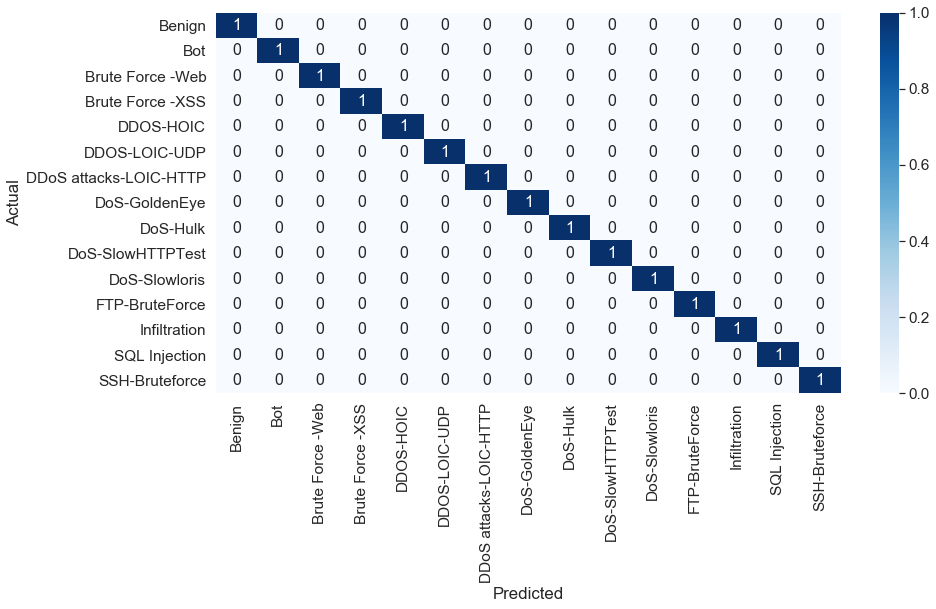

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df_cm =  pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4)
plt.figure(figsize = (14,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

### Important features

We can see the degree of contribution of each feature to the classification result by using the __feature\_importances\___ attribute of the Random Forest Classifier. We see here that, as mentioned in the paper, the 10 features extracted from our Adaptive Clustering network consistute the 10 most important features for the classifier.

In [18]:
print("Calculating feature importance scores...")
importances = model.classifier.cls.feature_importances_
indices = np.argsort(importances)[-50:][::-1]  # -50 #most important features
cols = test_df.columns.values.tolist()

feature_importances_list = []
for f in range(len(indices)):
    feature_importances_list.append([indices[f], cols[indices[f]], importances[indices[f]]])

with open(results_path + "rf_feature_importance_scores.pkl", "wb") as f:
    pkl.dump(feature_importances_list, f)
    print(f"Feature importance scores saved: {results_path}rf_feature_importance_scores.pkl")

    print("")
    print("15 most important features")
    pprint(feature_importances_list[:15])
    print("Sum 15:", np.sum(importances[indices[:15]]))
    print("")

Calculating feature importance scores...
Feature importance scores saved: ./demo_results/rf_feature_importance_scores.pkl

15 most important features
[[132, 'kernel_feature_5', 0.08178318461007863],
 [130, 'kernel_feature_3', 0.07565589316895451],
 [133, 'kernel_feature_6', 0.07246143605439102],
 [131, 'kernel_feature_4', 0.07058038540371375],
 [136, 'kernel_feature_9', 0.06855118911590024],
 [134, 'kernel_feature_7', 0.06495256484992366],
 [128, 'kernel_feature_1', 0.061312813711989],
 [129, 'kernel_feature_2', 0.058819080203644805],
 [127, 'kernel_feature_0', 0.05493784130054764],
 [135, 'kernel_feature_8', 0.05281658873364255],
 [69, 'payload_feature_30', 0.021296088569098],
 [80, 'payload_feature_41', 0.02048442810056399],
 [112, 'Init Fwd Win Byts', 0.018483005609833966],
 [46, 'payload_feature_7', 0.01647526842298469],
 [118, 'Fwd Seg Size Min', 0.016135304627073335]]
Sum 15: 0.7547450724823399



### Performance metrics

Finally, we compute the different performance metrics on our test set. We can see here again that this approach allows us to obtain a perfect score on every single evaluation metric, making this the new state-of-the-art approach for classification tasks.

In [19]:
print("Calculating performance metrics...")
cnf_matrix = confusion_matrix(y_actual_, y_hat)
_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
_tp = np.diag(cnf_matrix)
_tn = cnf_matrix.sum() - (_fp + _fn + _tp)

_fp = _fp.astype(float)
_fn = _fn.astype(float)
_tp = _tp.astype(float)
_tn = _tn.astype(float)

_fp = np.mean(_fp)
_fn = np.mean(_fn)
_tp = np.mean(_tp)
_tn = np.mean(_tn)

metrics_handler = metrics(tp=_tp, tn=_tn, fp=_fp, fn=_fn)
metrics_data = metrics_handler.get_metrics()

accuracy = accuracy_score(y_actual_, y_hat)
precision, recall, f_score, support = prf(y_actual_, y_hat, average='weighted')
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}, FAR: {:0.4f}"
                                                      .format(accuracy, precision,
                                                              recall, f_score, metrics_data["FAR"]))

with open(results_path + "metrics_handler.pkl", "wb") as f:
    pkl.dump(metrics_handler, f)
    print(f"Performance metrics saved: {results_path}metrics_handler.pkl")

print(separator)

Calculating performance metrics...
Accuracy : 1.0000, Precision : 1.0000, Recall : 1.0000, F-score : 1.0000, FAR: 0.0000
Performance metrics saved: ./demo_results/metrics_handler.pkl
--------------------------------------------------


### Putting it all together

<p style="font-size: 1.2em; line-height: 1.2em;">We have implemented our approach and obtained a striking state-of-the-art performance by producing a <b>100%</b> success rate with <b>zero</b> false alarms on the CSE-CIC-IDS 2018 intrusion detection dataset. We have also shown that the features learned from the proposed classifier-agnostic Adaptive Clustering network constitute the features that participate the most to the decision process of the final classifier.</p>